<a href="https://colab.research.google.com/github/imZiho/Deep-Learning_Seminar/blob/main/CHA07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **다중분류**

기존 3개의 붓꽃데이터셋을 2종류로 줄여 이진분류에 사용했지만
여기서는 세 종류 모두 학습 데이터로 사용한다.

(이진분류와의 차이점)

1. 이진분류의 예측에서 사용한 시그모이드 함수가 소프트맥스함수로 불리는 별개의 함수로 바뀐다

2. 손실함수는 교차엔트로피 함수 그대로 사용하지만 형식에는 차이가 있다

3. 이진분류에서는 가중치 벡터였으나 다중분류에서는 가중치 행렬로 대체된다

**소프트맥스 함수란?**

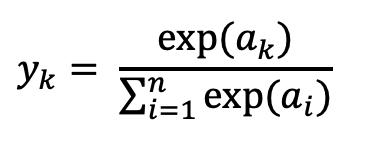

위와 같은 식으로 표현되는 함수이며 시그모이드 함수와 마찬가지로 출력으로 확률값을 내주는 성질을 갖는다.


소프트맥스함수는 입력 중에서 가장 큰 값의 확률이 가장 크도로 출력한다

즉 파이토치의 레이어 함수인 선형함수와 소프트맥스 함수를 이어 붙이면 여러 확률 값을 반환하는 예측모델을 구성할 수 있다.

**교차 엔트로피 함수**

교차 엔트로피 함수는 소프트맥스 함수의 중간 텐서 안의 모든 요소들에 대해 로그를 취해 정갑 요소만을 골라낸다.